In [272]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [273]:
model_params = {
    'reaction_speed': 10, # the size of step of signal in binary model
    'max_reward': 300, # maximum reward for iteration
    'angle_loss_coeff': 1e3, #300000 # coef before punish for dismiss an angle
    'over_force_loss_coeff': 0, # coef before punish for inapropriate force (signals out of range [800, 2300])
    'upper_force_loss_coeff': 10., #3 # coef before punish for missing total force on y-axis. target_force is a target.
    'step_size': 1e-3, # time length of iteration in seconds
    'target_upper_force': 2.0, # total force on y-axis which wanted to be achieved and stated.
    'gamma': 0.99, # discount factor
}

False


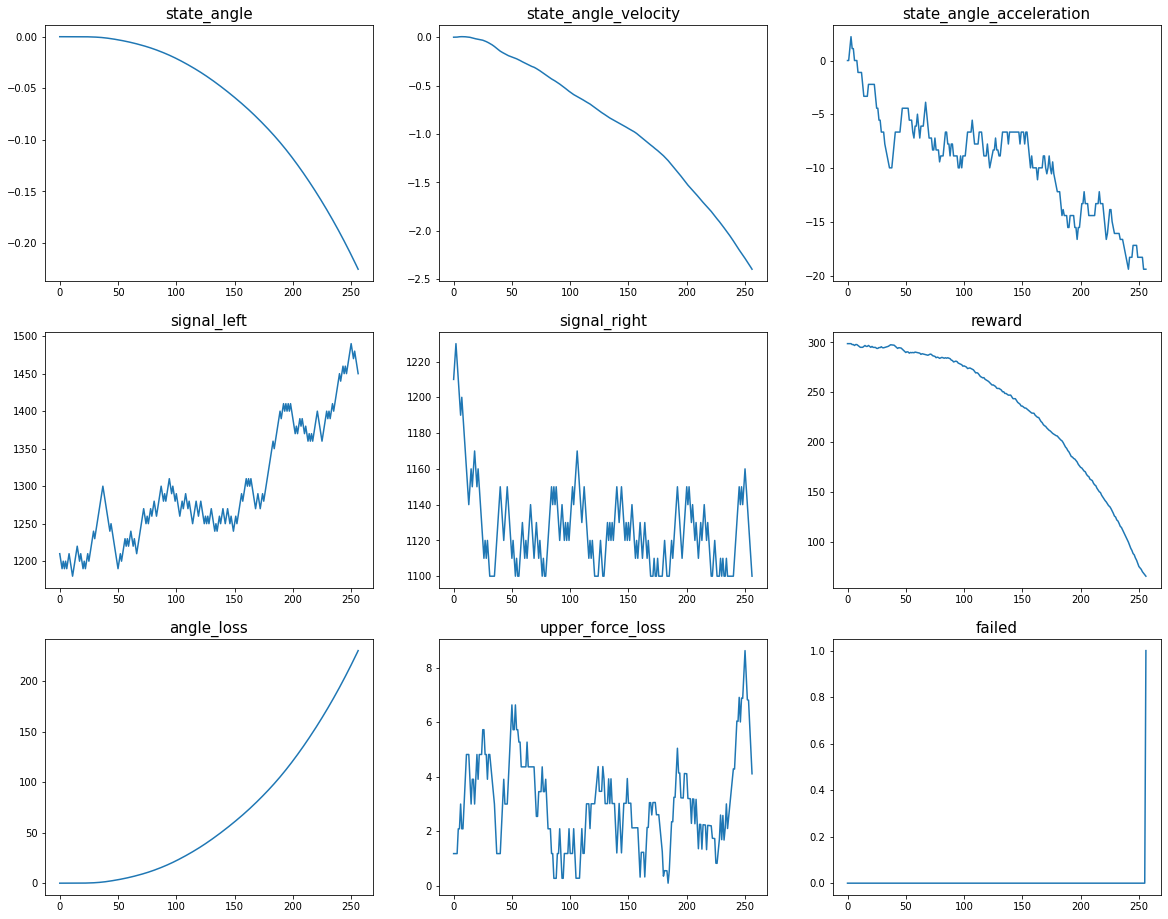

In [274]:
import matplotlib.pyplot as plt
from Copter.Session import Session
from Copter.Network import Network, FakeNet
net = FakeNet(3, 4)
s = Session(network=net, **model_params)
s.run(1000)
print(s.success)
# s.logs
s.plot_logs()


In [275]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from utils import to_one_hot

class Trainer(object):
    def __init__(self):
        self.network = Network(5, 4)
        self.session = Session(network=self.network, **model_params)
        self.n_sessions = 100
        self.percentile = 0.7

        self.optimizer = torch.optim.Adam(self.network.parameters(), 1e-3)
        self.entropy_coef = 0.01 # for loss functions
        self.train_log_rewards = [] # log of rewards for all steps (not session iterations)
        self.train_log_iters = []

    def generate_elites(self):
        '''
        Generates `n_session` sessions then choose just `percentile` best of them by total reward.
        Returns state_tensor, action_tensor_left, action_tensor_right which correspond to states and actions of concatenation
        of the best sessions.
        '''
        total_rewards = []
        state_tensors = []
        action_tensors_left = []
        action_tensors_right = []
        for _ in range(self.n_sessions):
            self.session.run(reset=True)
            total_rewards.append(self.session.total_reward)
            state_tensors.append(self.session.get_state_tensor())
            action_tensor_left, action_tensor_right = self.session.get_action_tensors() 
            action_tensors_left.append(action_tensor_left)
            action_tensors_right.append(action_tensor_right)
            # print(session_tensors[-1].shape)
        self.session.reset()

        reward_threshold = np.percentile(total_rewards, self.percentile)        
        elite_states = torch.vstack([state_tensors[i] for i in range(self.n_sessions) if reward_threshold <= total_rewards[i]])
        elite_actions_left = torch.vstack([action_tensors_left[i] for i in range(self.n_sessions) if reward_threshold <= total_rewards[i]])
        elite_actions_right = torch.vstack([action_tensors_right[i] for i in range(self.n_sessions) if reward_threshold <= total_rewards[i]])

        return elite_states, elite_actions_left, elite_actions_right
    
    def train_model_step(self):
        '''
        Makes a step of CEM algorithm
        '''
        states_tensor, actions_left_tensor, actions_right_tensor = self.generate_elites()
        # actions_left_tensor = torch.vstack(self.action_history_left)
        # actions_right_tensor = torch.vstack(self.action_history_right)
        cumulative_rewards_tensor = torch.tensor(self.get_cumulative_rewards(), dtype=torch.float32)

        logits = self.network(states_tensor)
        left_log_logits = F.log_softmax(logits[:, :2], -1)
        right_log_logits = F.log_softmax(logits[:, 2:], -1)
        log_probs_for_actions = torch.sum(left_log_logits * actions_left_tensor + right_log_logits * actions_right_tensor, dim=1) 
        
        entropy = (torch.exp(log_probs_for_actions) * log_probs_for_actions).sum()
        loss = -(log_probs_for_actions * cumulative_rewards_tensor).mean() - entropy * self.entropy_coef

        # log_prob = get_log_prob(actions_tensor, preds, self.model.std)
        # loss = -(log_prob * cumulative_rewards_tensor).mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return self.model.total_reward

    def train_model(self, train__steps=10, run_iterations=100, print_=True):
        '''
        Trains model for several steps.
        '''
        for step in range(train__steps):
            self.run(run_iterations)
            reward = self.train_model_step()
            self.train_log_rewards.append(reward)
            self.train_log_iters.append(self.iteration)
            if print_:
                print(step, reward, self.iteration)

    def plot_trained_logs(self, window_size=10):
        r = np.convolve(self.train_log_rewards, np.ones(window_size), 'valid') / window_size
        i = np.convolve(self.train_log_iters, np.ones(window_size), 'valid') / window_size
        plt.xlabel('step')
        plt.ylabel('reward')
        plt.title('rolling reward')
        plt.plot(r)
        plt.show()
        plt.xlabel('step')
        plt.ylabel('iterations')
        plt.title('rolling num of iterations')
        plt.plot(i)
        plt.show()


In [277]:
tr = Trainer()
# tr.generate_sessions(100, 0.7).shape
# torch.vstack(t).shape

torch.Size([10000, 5])

In [237]:
reward_threshold = np.percentile(r, 0.7)
# [t[i] for i in range(10) if reward_threshold <= r[i]]

In [4]:
net = Network(3, 4)
s = Session(net, **model_params)

In [28]:
# s.model.compute_angle_acceleration(6.) * 0.1
from utils import signal_to_force, compute_total_J
from model_parameters import MOTOR_DISTANCE, MAX_ANGLE
# signal_to_force(2300)
# j = compute_total_J(True)
(s.model.compute_angle_acceleration(6) * MAX_ANGLE * 0.9 / 180 * 3.1415 * 2)**0.5 * 180 / 3.1415

330.7851343621104

In [15]:
s.train_model(10, 1000, False)

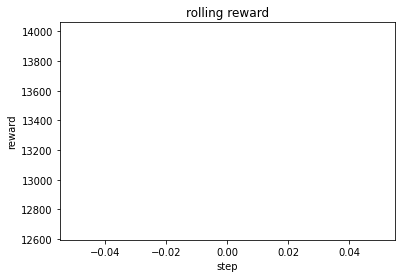

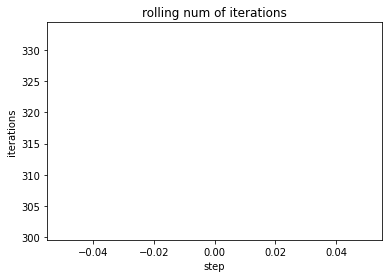

In [16]:
s.plot_trained_logs(window_size=10)

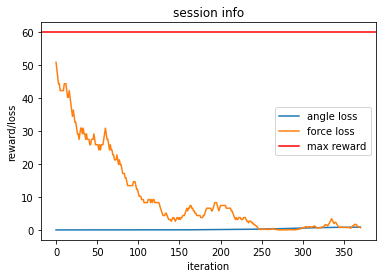

In [17]:
s.plot_info()

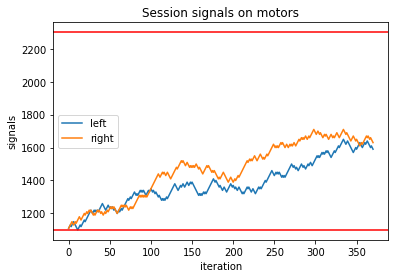

In [18]:
s.plot_signals()

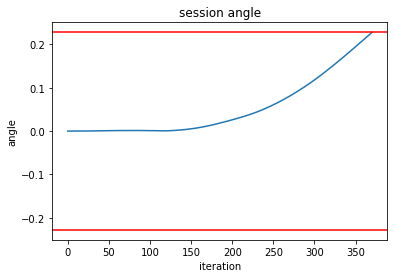

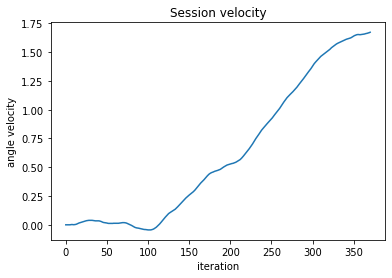

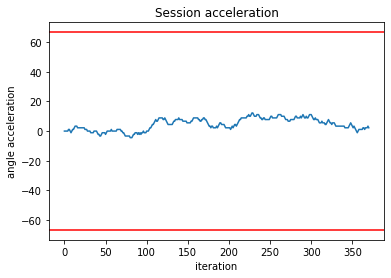

In [19]:
s.plot_states()

In [332]:
s.plot_actions()

AttributeError: 'Session' object has no attribute 'plot_actions'

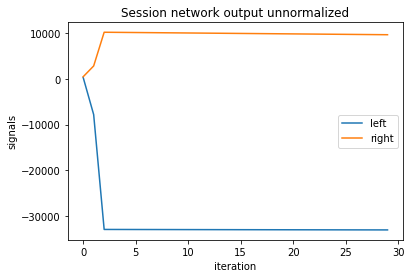

In [145]:
s.plot_signals()

In [14]:
from utils import compute_total_J
compute_total_J(False)

21.8


12956637.786666665

In [63]:
from Copter.Session import Session
s = Session()
s.run(10)

d:\STUDY\code\ML notebooks\my\copter\Copter\TwoMotorStick.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probas = F.softmax(logits).numpy()


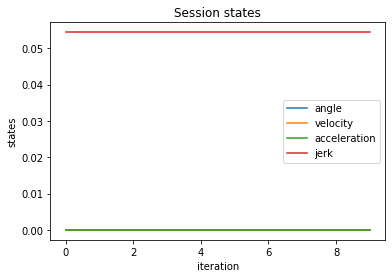

In [64]:
s.plot_states()

In [1]:
# all parameters in mm's and gramms

# STICK_LENGTH = 370.
# STICK_HEIGHT = 59.
# STICK_MASS = 196.

# MOTOR_MASS = 67.
# MOTOR_DISTANCE = 158.
# MOTOR_HEIGHT = 50.

# REGULATOR_MASS = 24.
# REGULATOR_DISTANCE = 70.
# REGULATOR_HEIGHT = 32.

# CENTER_AXIS_IDENT = 17.5
# PILLAR_HEIGH = 0
from model_parameters import *
2 * (MOTOR_MASS * MOTOR_HEIGHT + REGULATOR_MASS * REGULATOR_HEIGHT) \
    / (2 * MOTOR_MASS + 2 * REGULATOR_MASS + STICK_MASS)

21.788359788359788

In [1]:
import torch

In [10]:
a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5, 6])
c = torch.vstack([a, b])
torch.square(c)

tensor([[ 1,  4,  9],
        [16, 25, 36]])

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch


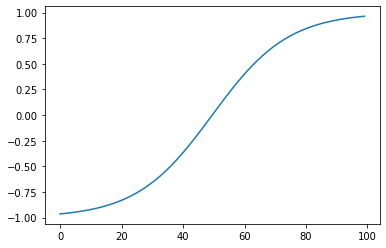

In [22]:
space = np.linspace(-2, 2, 100)
ans = []
for a in space:
    ans.append(torch.tanh(torch.tensor(a)).item())
plt.plot(ans)

In [44]:
import math
mean = 1
var = 1

In [45]:
np.random.normal(mean, var)

1.3196001152839887

In [46]:
a = np.array([1, 3])
a.tolist()

[1, 3]

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [167]:
df = pd.read_csv('Motor force detection.csv')

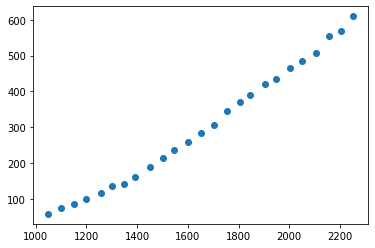

In [168]:
plt.scatter(x=df.input, y=df.mass)

In [169]:
lr = LinearRegression()
lr.fit(df.drop('mass', axis=1), df.mass)

LinearRegression()

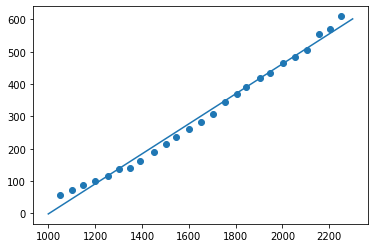

In [170]:
space = np.linspace(1000, 2300)
preds = lr.intercept_ + lr.coef_[0] * space
plt.plot(space, preds)
plt.scatter(x=df.input, y=df.mass)
plt.show()

In [171]:
np.array([lr.intercept_, lr.coef_[0]]) * 1e-3 * 9.8

array([-4.56204418e+00,  4.54791687e-03])

In [172]:
lr.predict(np.array([[2300]]))

array([601.85353414])

In [173]:
np.random.choice(2, 1, p=np.array([0.3, 0.7]))[0]

[autoreload of Copter.TwoMotorStick failed: Traceback (most recent call last):
  File "C:\Users\Danill\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Danill\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\Danill\AppData\Local\Programs\Python\Python37\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Users\Danill\AppData\Local\Programs\Python\Python37\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "d:\STUDY\code\ML notebooks\my\copter\Copter\TwoMotorStick.py", line 4, in 

1

In [192]:
a = torch.rand(4,4)
a

tensor([[0.1376, 0.8149, 0.3219, 0.1905],
        [0.3193, 0.3232, 0.3588, 0.0897],
        [0.7505, 0.8373, 0.6066, 0.6727],
        [0.3603, 0.9797, 0.6747, 0.3969]])

In [193]:
a[:, :2]

tensor([[0.1376, 0.8149],
        [0.3193, 0.3232],
        [0.7505, 0.8373],
        [0.3603, 0.9797]])